In [66]:
import pandas as pd
import sqlite3
from sqlite3 import Error

In [65]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

import pandas as pd
df=pd.read_csv('AB_US_2020.csv')
df.to_csv('airbnb_new_data.tsv',sep='\t')


In [ ]:
'id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city'

## GET AIRBNB DATA INTO SQL DB without city data##

In [67]:


def csv_to_db(file_name,table_name,db_name,create_sql_statement,columns):
    with open(file_name, encoding="mbcs") as fl:
        cnt=0
        data=[]
        for lines in fl:
            #print(lines)
            if cnt!=0:
                lst=lines.strip().split('\t')
                row_tmp = tuple(lst) 
                if len(row_tmp)==18:
                    data.append(row_tmp)
            cnt+=1
    ##print(data)
    conn = create_connection(db_name)
    cur = conn.cursor()
    
    ### CREATE TABLE ##
    create_table(conn,create_sql_statement,table_name)
    
    ### get number of columns
    col_num=len(columns.split(','))
    insert_sql='insert into '+str(table_name)+' values('
    for i in range(col_num):
        insert_sql+='?,'
    
    insert_sql=insert_sql[:-1]+')'
    print(insert_sql)
    
    
    cur.executemany(insert_sql,data)
    conn.commit()
    conn.close()
    
    return data


    
create_table_sql='''
 create table airbnb_data (
          row_id integer primary key not null,
          id integer,
          name text,
          host_id integer,
          host_name text,
          neighbourhood_group text,
          neighbourhood text,
          latitude real,
          longitude real,
          room_type text,
          price real,
          minimum_nights integer,
          number_of_reviews integer,
          last_review text,
          reviews_per_month real,
          calculated_host_listings_count integer,
          availability_365 integer,
          city text
        );
'''
data = csv_to_db('airbnb_new_data.tsv','airbnb_data','airbnb.db',create_table_sql,'row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city')





insert into airbnb_data values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)


## GET US CITY DATA INTO SQL DB ##


In [68]:
def city_state_us(file_name,db_name,table_name,columns,create_table_sql):
    with open(file_name, encoding="mbcs") as fl:
            cnt=0
            data=[]
            for lines in fl:
                ##print(lines)
                if cnt!=0:
                    lst=lines.strip().split(',')
                    row_tmp = tuple(lst)
                    data.append(row_tmp)
                cnt+=1
        
        ##print(data)
        
    conn = create_connection(db_name)
    cur = conn.cursor()

    ### CREATE TABLE ##
    create_table(conn,create_table_sql,table_name)
                
    ### get number of columns
    col_num=len(columns.split(','))
    insert_sql='insert into '+str(table_name)+' values('
    for i in range(col_num):
        insert_sql+='?,'
    insert_sql=insert_sql[:-1]+')'
    print(insert_sql)
        
    ### INSERT INTO TABLE ###
    cur.executemany(insert_sql,data)
    conn.commit()
    conn.close()
    return data

create_table_sql_city_states='''
 create table city_state_mapping (
          ID integer not null primary key,
          STATE_CODE text,
          STATE_NAME text,
          CITY text,
          COUNTY text,
          LATITUDE real,
          LONGITUDE real
        );
'''
data1= city_state_us('us_cities.csv','airbnb.db','city_state_mapping','ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE',create_table_sql_city_states)

insert into city_state_mapping values(?,?,?,?,?,?,?)


## CHECK  if cities in airbnb dataset have duplicate names present in city state dataset ##

In [69]:
def sql_query(sql_statement,db_name):
    conn = create_connection(db_name)
    cur = conn.cursor()
    df =pd.read_sql_query(sql_statement, conn)    
    conn.commit()
    conn.close()
    return df

sql=''' 
select a.city,count(*) from 
(select distinct case when substr(city,1,1)='"' then lower(trim(substr(city,2,length(city)-2))) else lower(trim(city)) end as city from city_state_mapping
) a
where lower(trim(city)) in (
select distinct case when substr(city,1,1)='"' then lower(trim(substr(city,2,length(city)-2))) else lower(trim(city)) end as city from airbnb_data
)
group by a.city;
          '''


sql=''' 
select * from city_state_mapping where city ='London';
          '''

sql_query(sql,'airbnb.db')

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
0,1143,AR,Arkansas,London,Pope,35.337017,-93.238907
1,9222,KY,Kentucky,London,Laurel,37.101605,-84.097498
2,20022,OH,Ohio,London,Madison,39.900074,-83.443899
3,25604,TX,Texas,London,Kimble,30.617101,-99.625527
4,29349,WV,"""West Virginia""",London,Kanawha,38.194444,-81.368889


## Check the city distribution of AIRBNBs ##

In [70]:

sql=''' 
select a.city,count(*) from 
airbnb_data a
where lower(trim(city)) in (
select distinct case when substr(city,1,1)='"' then lower(trim(substr(city,2,length(city)-2))) else lower(trim(city)) end as city from airbnb_data
)
group by a.city
order by count(*) desc
'''
sql_query(sql,'airbnb.db')


,city,count(*)
0,New York City,45629
1,Los Angeles,31397
2,Hawaii,22385
3,San Diego,12360
4,Broward County,10815
5,Austin,10415
6,Clark County,8369
7,Washington D.C.,7343
8,San Clara Country,7078
9,San Francisco,7044


## CITY STATE MAPPING TABLE FORMATTED ##

In [71]:

def sql_query_create_table_as(sql_statement,db_name):
    conn = create_connection(db_name)
    cur = conn.cursor()
    cur.execute(sql)    
    conn.commit()
    conn.close()

sql='''
create table state_city_mapping_transformed as
select  id,state_code,case when substr(STATE_NAME,1,1)='"' then trim(substr(STATE_NAME,2,length(STATE_NAME)-2)) else trim(STATE_NAME) end as state_name,case when substr(COUNTY,1,1)='"' then trim(substr(COUNTY,2,length(COUNTY)-2)) else trim(COUNTY) end as county,LATITUDE,LONGITUDE,case when substr(city,1,1)='"' then trim(substr(city,2,length(city)-2)) else trim(city) end as city from city_state_mapping'''

sql_query_create_table_as(sql,'airbnb.db')


OperationalError: table state_city_mapping_transformed already exists

## Transformed CITY STATE dataset ##

In [72]:
sql_query('select * from state_city_mapping_transformed','airbnb.db')

,ID,STATE_CODE,state_name,county,LATITUDE,LONGITUDE,city
0,1,AK,Alaska,Aleutians West,55.999722,-161.207778,Adak
1,2,AK,Alaska,Bethel,60.891854,-161.392330,Akiachak
2,3,AK,Alaska,Bethel,60.890632,-161.199325,Akiak
3,4,AK,Alaska,Aleutians East,54.143012,-165.785368,Akutan
4,5,AK,Alaska,Kusilvak,62.746967,-164.602280,Alakanuk
...,...,...,...,...,...,...,...
29875,29876,WY,Wyoming,Washakie,44.013796,-107.956260,Worland
29876,29877,WY,Wyoming,Campbell,43.829349,-105.532327,Wright
29877,29878,WY,Wyoming,Sheridan,44.813333,-106.773333,Wyarno
29878,29879,WY,Wyoming,Park,44.853913,-110.674366,Yellowstone National Park


### API to get state names from GEOCODE ###

In [ ]:
!pip install geopy


In [75]:
from geopy.geocoders import Nominatim

# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")
Latitude = "35.65146"
Longitude = "-82.62791999999999"
location = geolocator.reverse(Latitude+","+Longitude)
address=location.raw['address']  
# Display
print(address.get('state'))

North Carolina


## UPDATED INGESTION WITH STATE NAMES ##

In [78]:


def csv_to_db(file_name,table_name,db_name,create_sql_statement,columns):
    geolocator = Nominatim(user_agent="geoapiExercises")
    
    with open(file_name, encoding="mbcs") as fl:
        cnt=0
        data=[]
        for lines in fl:
            #print(lines)
            if cnt!=0:
                
                lst=lines.strip().split('\t')
                if len(lst)==18:
                    data.append(lst)
            cnt+=1
    ##print(data)
    conn = create_connection(db_name)
    cur = conn.cursor()
    
    ### CREATE TABLE ##
    create_table(conn,create_sql_statement,table_name)
    
    
    #### GET distinct city names ###
    city={}
    for i in data:
        if i[-1] not in city.keys():
            city[i[-1]]=(i[7],i[8])
    
    
    #### mapping latitudes to states ####
    
    for i in city.keys():
        Latitude = city[i][0]
        Longitude = city[i][1]
        #print(Latitude,Longitude)
        location = geolocator.reverse(Latitude+","+Longitude)
        #print(i,location)
        address=location.raw['address']
        state=address.get('state')
        
        city[i]=state
    
    #### ADD states to existing data ###
    
    final_data=[]
    for i in data:
        i.append(city[i[-1]])
        final_data.append(tuple(i))
    
    
    ### get number of columns
    col_num=len(columns.split(','))
    insert_sql='insert into '+str(table_name)+' values('
    for i in range(col_num):
        insert_sql+='?,'
    
    insert_sql=insert_sql[:-1]+')'
    print(insert_sql)
    
    
    cur.executemany(insert_sql,final_data)
    conn.commit()
    conn.close()
    
    return data,city


    
create_table_sql='''
 create table airbnb_data_new (
          row_id integer primary key not null,
          id integer,
          name text,
          host_id integer,
          host_name text,
          neighbourhood_group text,
          neighbourhood text,
          latitude real,
          longitude real,
          room_type text,
          price real,
          minimum_nights integer,
          number_of_reviews integer,
          last_review text,
          reviews_per_month real,
          calculated_host_listings_count integer,
          availability_365 integer,
          city text,
          state text
        );
'''
data,city = csv_to_db('airbnb_new_data.tsv','airbnb_data_new','airbnb.db',create_table_sql,'row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,state')




insert into airbnb_data_new values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)


In [22]:
city

{'Asheville': 'North Carolina',
 'Austin': 'Texas',
 'Boston': 'Massachusetts',
 'Broward County': 'Florida',
 'Cambridge': 'Massachusetts',
 'Chicago': 'Illinois',
 'Clark County': 'Nevada',
 'Columbus': 'Ohio',
 'Denver': 'Colorado',
 'Hawaii': 'Hawaii',
 'Jersey City': 'New Jersey',
 'Los Angeles': 'California',
 'Nashville': 'Tennessee',
 'New Orleans': 'Louisiana',
 'New York City': 'New York',
 'Oakland': 'California',
 'Pacific Grove': 'California',
 'Portland': 'Oregon',
 'Rhode Island': 'Rhode Island',
 'Salem': 'Oregon',
 'San Clara Country': 'California',
 'San Diego': 'California',
 'San Francisco': 'California',
 'San Mateo County': 'California',
 'Santa Cruz County': 'California',
 'Seattle': 'Washington',
 'Twin Cities MSA': 'Minnesota',
 'Washington D.C.': 'District of Columbia'}

In [79]:
sql=''' select * from airbnb_data_new'''
df_airbnb_listing = sql_query(sql,'airbnb.db')

## Ingest Crime Data ##

In [12]:
def create_crime_table(data_filename, normalized_database_filename):

    conn = create_connection(normalized_database_filename)
       
    create_table_crime_sql = """ CREATE TABLE [Crime] (
    [County] TEXT NOT NULL PRIMARY KEY,
    [Population_2020] TEXT NOT NULL,
    [Index_Crime_Count] TEXT NOT NULL,
    [Index_Crime_Rate] TEXT NOT NULL,
    [Violent_Crime_Count] TEXT NOT NULL,
    [Violent_Crime_Rate] TEXT NOT NULL,
    [Property_Crime_Count] TEXT NOT NULL,
    [Property_Crime_Rate] TEXT NOT NULL, 
    [Violent_Crime_With_Firearm_Count] TEXT NOT NULL,
    [Violent_Crime_With_Firearm_Rate] TEXT NOT NULL
    ); """
    
    def insert_crime(conn, values):
        sql = ''' INSERT INTO Crime(County
        ,Population_2020
        ,Index_Crime_Count
        ,Index_Crime_Rate
        ,Violent_Crime_Count
        ,Violent_Crime_Rate
        ,Property_Crime_Count
        ,Property_Crime_Rate
        ,Violent_Crime_With_Firearm_Count
        ,Violent_Crime_With_Firearm_Rate)
        VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?) '''
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid    

    with open(data_filename, 'r') as f:
        crime_lst = []
        for line in f:
            if line.split('\t') not in crime_lst:
                crime_lst.append(line.rstrip('\n').split('\t'))
        crime_lst=sorted(crime_lst[1:])
        
    with conn:
        lst_tup_reg=[]
        lst=[]
        create_table(conn, create_table_crime_sql,'crime')
        for i in range(len(crime_lst)):
            lst_tup_reg.append(tuple(''.join(crime_lst[i]).split(',')))
        insert_crime(conn,lst_tup_reg)

In [81]:
data_filename = '2020-county-index-rates.csv'
normalized_database_filename = 'airbnb.db'
create_crime_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_crime_ny = pd.read_sql_query("""SELECT * FROM Crime""", conn)
print(df)
conn.close()

Table created
IE
    Longitude1  Latitude1                                   Long_Campus_Name  \
0   -73.056457  40.848156  SUFFOLK COUNTY COMMUNITY COLLEGE-AMMERMAN CAMP...   
1   -73.122688  40.918159        STATE UNIVERSITY OF NEW YORK AT STONY BROOK   
2   -73.427879  40.752811  STATE UNIVERSITY OF NEW YORK COLLEGE OF TECHNO...   
3   -73.467255  44.693741                          CLINTON COMMUNITY COLLEGE   
4   -73.467545  44.694538            STATE UNIVERSITY COLLEGE AT PLATTSBURGH   
..         ...        ...                                                ...   
56  -78.873161  42.881912                 ERIE COMMUNITY COLLEGE-CITY CAMPUS   
57  -78.876892  42.932419                STATE UNIVERSITY COLLEGE AT BUFFALO   
58  -78.882858  43.144421                   NIAGARA COUNTY COMMUNITY COLLEGE   
59  -79.217926  42.112953                        JAMESTOWN COMMUNITY COLLEGE   
60  -79.320724  42.438595               STATE UNIVERSITY COLLEGE AT FREDONIA   

       Campus_Name    

## Ingest University Information ##

In [60]:
 def create_univ_table(data_filename, normalized_database_filename,drop_table_name=None):
    conn = create_connection(normalized_database_filename)
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)

#Longitude1	Latitude1	Campus Name	Long Campus Name	Address 1	Address 2	City	State	Zip	County	Institution Level	Institution Type	
#Enrollment As Of	Undergraduate Enrollment	Graduate Enrollment	Program 1	Program 2	Program 3	Program 4	Program 5	Campus Website
    create_table_univ_sql = """ CREATE TABLE [University] (
    [Longitude1] REAL NOT NULL ,
    [Latitude1] REAL NOT NULL,
    Long_Campus_Name TEXT,
    [Campus_Name] TEXT NOT NULL PRIMARY KEY,
    [Address_1] TEXT NOT NULL,
    [Address_2] TEXT,
    [City] TEXT NOT NULL,
    [State] TEXT NOT NULL,
    [Zip] INT NOT NULL, 
    [County] TEXT NOT NULL,
    [Institution_Level] TEXT NOT NULL,
    [Institution_Type] TEXT NOT NULL,
    [Enrollment_As_Of] TEXT NOT NULL,
    Undergrad_enroll integer not NULL,
    [Graduate_Enrollment] TEXT NOT NULL,
    [Program_1] TEXT NOT NULL,
    [Program_2] TEXT NOT NULL,
    [Program_3] TEXT NOT NULL,
    [Program_4] TEXT NOT NULL,
    [Program_5] TEXT NOT NULL,
    [Campus_Website] TEXT NOT NULL
    
    
    ); """
    
    def insert_university(conn, values):
        sql = ''' INSERT INTO [University] (Longitude1
        ,Latitude1
        ,Campus_Name
        ,Long_Campus_Name
        ,Address_1
        ,Address_2
        ,City
        ,State
        ,Zip
        ,County
        ,Institution_Level
        ,Institution_Type
        ,Enrollment_As_Of
        ,Undergrad_enroll
        ,Graduate_Enrollment
        ,Program_1
        ,Program_2
        ,Program_3
        ,Program_4
        ,Program_5
        ,Campus_Website)
        VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?,?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?)'''
        cur = conn.cursor()
        cur.executemany(sql, values)
        return cur.lastrowid    

    with open(data_filename, 'r') as f:
        university_lst = []
        for line in f:
            if line.split('\t')[1:] not in university_lst:
                university_lst.append(tuple(line.split('\t')[1:]))
        university_lst=sorted(university_lst[1:])
        print(len(university_lst[0]))
        print(university_lst[0])
    with conn:

        try:
            create_table(conn, create_table_univ_sql,'University')
            print('Table created')
        except:
            print('Table not created')

        try:

            insert_university(conn,university_lst)
        except:
            print("IE") 

In [18]:
create_univ_table('university_list_ny.csv', 'airbnb.db')
    
    

Table created
IE


In [85]:
##data_filename = 'university_list_ny.csv'
##df_tmp = pd.read_csv('university_list_ny.csv')
normalized_database_filename = 'airbnb.db'
data_filename = 'univ_list_ny_new.tsv'
create_univ_table(data_filename, normalized_database_filename,'University')
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_univ_ny = pd.read_sql_query("""SELECT * FROM University;""", conn)
conn.close()

21
('-73.0564575', '40.848156', 'Suffolk County', 'SUFFOLK COUNTY COMMUNITY COLLEGE-AMMERMAN CAMPUS AT SELDEN', '533 COLLEGE RD', ' ', 'SELDEN', 'NY', '11784', 'Suffolk', '2-year', 'Community Colleges', 'Fall 2018', '26,078', '0', 'Lib Arts & Sci--General Studies', 'Lib Arts & Sci-General Studies', 'Lib Arts & Science-General Studies', 'Criminal Justice: Police', 'Business--Business Administration', 'http://www.sunysuffolk.edu\n')
Table created


In [45]:
##df_tmp.to_csv('univ_list_ny_new.tsv',sep='\t')

In [64]:
df.dtypes

Longitude1             float64
Latitude1              float64
Long_Campus_Name        object
Campus_Name             object
Address_1               object
Address_2               object
City                    object
State                   object
Zip                      int64
County                  object
Institution_Level       object
Institution_Type        object
Enrollment_As_Of        object
Undergrad_enroll        object
Graduate_Enrollment     object
Program_1               object
Program_2               object
Program_3               object
Program_4               object
Program_5               object
Campus_Website          object
dtype: object

## NORMALIZE DATASET ##

## Other Datasets ingest ##

In [80]:
df_airbnb_listing

,row_id,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,state
0,0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,,28804,35.651460,-82.627920,Private room,60.0,1,138,16/02/20,1.14,1,0,Asheville,North Carolina
1,1,80905,French Chic Loft,427027,Celeste,,28801,35.597790,-82.555400,Entire home/apt,470.0,1,114,07/09/20,1.03,11,288,Asheville,North Carolina
2,2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,,28801,35.606700,-82.555630,Entire home/apt,75.0,30,89,30/11/19,0.81,2,298,Asheville,North Carolina
3,3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,,28806,35.578640,-82.595780,Entire home/apt,90.0,1,267,22/09/20,2.39,5,0,Asheville,North Carolina
4,4,160594,Historic Grove Park,769252,Elizabeth,,28801,35.614420,-82.541270,Private room,125.0,30,58,19/10/15,0.52,1,0,Asheville,North Carolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225397,226025,45506143,"""DC Hidden In Plain """"Site""""""",25973146,Marci,,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.903880,-77.029730,Entire home/apt,104.0,1,0,,,2,99,Washington D.C.,District of Columbia
225398,226026,45511428,DC 3 BR w/ screen porch 3 blck to metro w/ par...,231133074,Thomas,,"Brookland, Brentwood, Langdon",38.920820,-76.990980,Entire home/apt,151.0,2,0,,,1,300,Washington D.C.,District of Columbia
225399,226027,45514685,Charming Penthouse Apt w/ Rooftop Terrace in L...,33758935,Bassem,,"Shaw, Logan Circle",38.911170,-77.033540,Entire home/apt,240.0,2,0,,,1,173,Washington D.C.,District of Columbia
225400,226028,45516412,Adams Morgan/Nat'l Zoo 1 BR Apt #32,23193071,Michael,,"Kalorama Heights, Adams Morgan, Lanier Heights",38.926630,-77.044360,Entire home/apt,60.0,21,0,,,5,362,Washington D.C.,District of Columbia


In [82]:
df_crime_ny

,County,Population_2020,Index_Crime_Count,Index_Crime_Rate,Violent_Crime_Count,Violent_Crime_Rate,Property_Crime_Count,Property_Crime_Rate,Violent_Crime_With_Firearm_Count,Violent_Crime_With_Firearm_Rate
0,Albany,303723.00,7412.00,2440.40,1115.00,367.10,6297.00,2073.30,238.00,78.40
1,Allegany,45491.00,401.00,881.50,73.00,160.50,328.00,721.00,9.00,19.80
2,Bronx,1413534.00,36217.00,2562.20,13129.00,928.80,23088.00,1633.40,1802.00,127.50
3,Broome,188206.00,5180.00,2752.30,660.00,350.70,4520.00,2401.60,92.00,48.90
4,Cattaraugus,73437.00,868.00,1182.00,125.00,170.20,743.00,1011.80,12.00,16.30
...,...,...,...,...,...,...,...,...,...,...
57,Washington,60583.00,350.00,577.70,79.00,130.40,271.00,447.30,2.00,3.30
58,Wayne,88933.00,1332.00,1497.80,170.00,191.20,1162.00,1306.60,16.00,18.00
59,Westchester,963247.00,10306.00,1069.90,1585.00,164.50,8721.00,905.40,229.00,23.80
60,Wyoming,39363.00,304.00,772.30,45.00,114.30,259.00,658.00,2.00,5.10


In [86]:
df_univ_ny

,Longitude1,Latitude1,Long_Campus_Name,Campus_Name,Address_1,Address_2,City,State,Zip,County,...,Institution_Type,Enrollment_As_Of,Undergrad_enroll,Graduate_Enrollment,Program_1,Program_2,Program_3,Program_4,Program_5,Campus_Website
0,-73.056457,40.848156,SUFFOLK COUNTY COMMUNITY COLLEGE-AMMERMAN CAMP...,Suffolk County,533 COLLEGE RD,,SELDEN,NY,11784,Suffolk,...,Community Colleges,Fall 2018,"26,078",0,Lib Arts & Sci--General Studies,Lib Arts & Sci-General Studies,Lib Arts & Science-General Studies,Criminal Justice: Police,Business--Business Administration,http://www.sunysuffolk.edu\n
1,-73.122688,40.918159,STATE UNIVERSITY OF NEW YORK AT STONY BROOK,Stony Brook,100 NICOLLS RD,,STONY BROOK,NY,11794,Suffolk,...,Doctoral Degree Granting Institutions,Fall 2018,"17,474","8,762",Biology,Computer Science,Business Management,Psychology,Health Science,http://www.sunysb.edu\n
2,-73.427879,40.752811,STATE UNIVERSITY OF NEW YORK COLLEGE OF TECHNO...,Farmingdale,2350 BROADHOLLOW RD,,FARMINGDALE,NY,11735,Suffolk,...,Technology Colleges,Fall 2018,"9,916",54,Business Management,"Science, Technology, & Society",Liberal Arts & Science,Computer Programming & Information Systems,Criminal Justice: Law Enforcement Technology,http://www.farmingdale.edu\n
3,-73.467255,44.693741,CLINTON COMMUNITY COLLEGE,Clinton,136 CLINTON POINT DR,,PLATTSBURGH,NY,12901,Clinton,...,Community Colleges,Fall 2018,"1,376",0,Liberal Arts & Sciences: Humanities & Social S...,Business: Business Administration,Criminal Justice,Undergraduate - Nursing,Liberal Arts & Sciences: Math & Science,http://www.clinton.edu/\n
4,-73.467545,44.694538,STATE UNIVERSITY COLLEGE AT PLATTSBURGH,Plattsburgh,101 BROAD STREET,,PLATTSBURGH,NY,12901,Clinton,...,Comprehensive Colleges,Fall 2018,"5,297",407,Psychology,Nursing,Criminal Justice,Business Administration,Accounting,http://www.plattsburgh.edu\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,-78.873161,42.881912,ERIE COMMUNITY COLLEGE-CITY CAMPUS,Erie,121 ELLICOTT ST,,BUFFALO,NY,14203,Erie,...,Community Colleges,Fall 2018,"10,529",0,Lib Arts & Sci-General Studies,Business: Business Administration,Liberal Arts & Sciences - General Studies,Criminal Justice,Nursing,http://www.ecc.edu\n
57,-78.876892,42.932419,STATE UNIVERSITY COLLEGE AT BUFFALO,Buffalo State,1300 ELMWOOD AVE,,BUFFALO,NY,14222,Erie,...,Comprehensive Colleges,Fall 2018,"8,082","1,036",Business Administration,Psychology,Biology,Criminal Justice,Multidisciplinary Studies,http://www.buffalostate.edu/\n
58,-78.882858,43.144421,NIAGARA COUNTY COMMUNITY COLLEGE,Niagara County,3111 SAUNDERS SETTLEMENT,,SANBORN,NY,14132,Niagara,...,Community Colleges,Fall 2018,"5,047",0,Liberal Arts & Sciences [Day Format],Liberal Arts & Sciences: Humanities & Social S...,Business: Business Administration,Nursing,Criminal Justice,http://www.niagaracc.suny.edu\n
59,-79.217926,42.112953,JAMESTOWN COMMUNITY COLLEGE,Jamestown,525 FALCONER ST,,JAMESTOWN,NY,14701,Chautauqua,...,Community Colleges,Fall 2018,"4,476",0,Individual Studies,Nursing,Bus--Business Administration,Human Services,Liberal Arts & Sciences: Mathematics & Science,http://www.sunyjcc.edu\n


## Exploratory Data Analysis ##

<AxesSubplot:xlabel='state'>

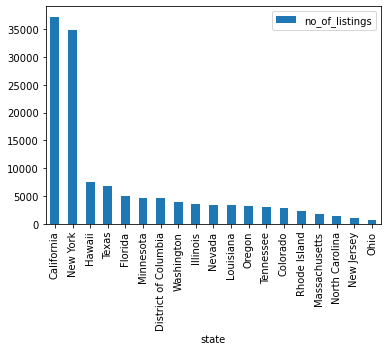

In [94]:
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df_airbnb_statewise = pd.read_sql_query("""SELECT state,count(distinct host_id) as no_of_listings FROM airbnb_data_new group by state order by no_of_listings desc;""", conn)
conn.commit()
conn.close()
df_airbnb_statewise.plot(kind='bar',x='state',y='no_of_listings')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

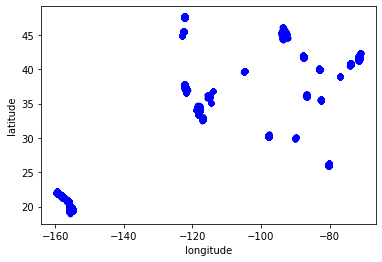

In [99]:
df_airbnb_listing.plot(x="longitude", y="latitude", kind="scatter", c="blue",
        colormap="YlOrRd")

In [100]:
!pip install geopandas

    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\HP\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-install-wrkfgu5l\\fiona\\setup.py'"'"'; __file__='"'"'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-install-wrkfgu5l\\fiona\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\HP\AppData\Local\Temp\pip-pip-egg-info-9npwht9y'
         cwd: C:\Users\HP\AppData\Local\Temp\pip-install-wrkfgu5l\fiona\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [101]:
import geopandas as gpd
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

ModuleNotFoundError: No module named 'geopandas'

In [104]:
!pip install fiona

  Using cached Fiona-1.8.20.tar.gz (1.3 MB)


    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\HP\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-install-mh0cvs_1\\fiona\\setup.py'"'"'; __file__='"'"'C:\\Users\\HP\\AppData\\Local\\Temp\\pip-install-mh0cvs_1\\fiona\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\HP\AppData\Local\Temp\pip-pip-egg-info-2tgwf32j'
         cwd: C:\Users\HP\AppData\Local\Temp\pip-install-mh0cvs_1\fiona\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.

The envir

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... 
  - defaults/win-64::curl-7.71.1-h86230a5_2, defaults/win-64::libcurl-7.71.1-h86230a5_2
  - defaults/win-64::curl-7.55.1-h3b839b5_4, defaults/win-64::libcurl-7.78.0-h86230a5_0done

## Package Plan ##

  environment location: C:\Users\HP\anaconda3

  added / updated specs:
    - fiona


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2020.07  |           py38_0           6 KB
    anaconda-custom            |           py38_1          36 KB
    ca-certificates-2021.10.26 |       haa95532_2         115 KB
    certifi-2021.10.8          |   py38haa95532_0         152 KB
    click-plugins-1.1.1        |     pyhd3eb1b0_0   